In [1]:
"""Gaskell Eros Shape Model V1.0 data set, ID:                           
        NEAR-A-MSI-5-EROSSHAPE-V1.0. """
%matplotlib notebook
import numpy as np, matplotlib.pyplot as plt, pymesh, trimesh
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
from points import *
from LS import *
from scipy.spatial.transform import Rotation as Rot
from numpy import pi as π, sin, cos, tan, sqrt, log, arctanh
from matplotlib import cm

In [ ]:
def fix_mesh(mesh, detail="normal"):
    bbox_min, bbox_max = mesh.bbox;
    diag_len = norm(bbox_max - bbox_min);
    if detail == "normal":
        target_len = diag_len * 2e-2;
    elif detail == "high":
        target_len = diag_len * 10e-3;
    elif detail == "low":
        target_len = diag_len * 4e-2;
    print("Target resolution: {} mm".format(target_len));

    count = 0;
    mesh, __ = pymesh.remove_degenerated_triangles(mesh, 100);
    mesh, __ = pymesh.split_long_edges(mesh, target_len);
    num_vertices = mesh.num_vertices;
    while True:
        mesh, __ = pymesh.collapse_short_edges(mesh, 1e-6);
        mesh, __ = pymesh.collapse_short_edges(mesh, target_len,
                preserve_feature=True);
        mesh, __ = pymesh.remove_obtuse_triangles(mesh, 150.0, 100);
        if mesh.num_vertices == num_vertices:
            break;

        num_vertices = mesh.num_vertices;
        print("#v: {}".format(num_vertices));
        count += 1;
        if count > 10: break;

    mesh = pymesh.resolve_self_intersection(mesh);
    mesh, __ = pymesh.remove_duplicated_faces(mesh);
    mesh = pymesh.compute_outer_hull(mesh);
    mesh, __ = pymesh.remove_duplicated_faces(mesh);
    mesh, __ = pymesh.remove_obtuse_triangles(mesh, 179.0, 5);
    mesh, __ = pymesh.remove_isolated_vertices(mesh);

    return mesh

P = np.loadtxt('erosP.dat',usecols=(1,2,3))
T = np.loadtxt('erosT.dat',usecols=(1,2,3)).astype(int)-1
mesh = pymesh.form_mesh(P,T)
mesh = fix_mesh(mesh,detail='low')

P = mesh.nodes
T = mesh.elements
I = trimesh.Trimesh(vertices=P,
                       faces=T,
                       process=False).moment_inertia
Ip, Q = trimesh.inertia.principal_axis(I)
P = matmul(P,Q.T)
T, N, C = surface_normals(P, T)

In [11]:
pymesh.meshio.save_mesh('eros_normal_detail.mesh', mesh)

<IPython.core.display.Javascript object>


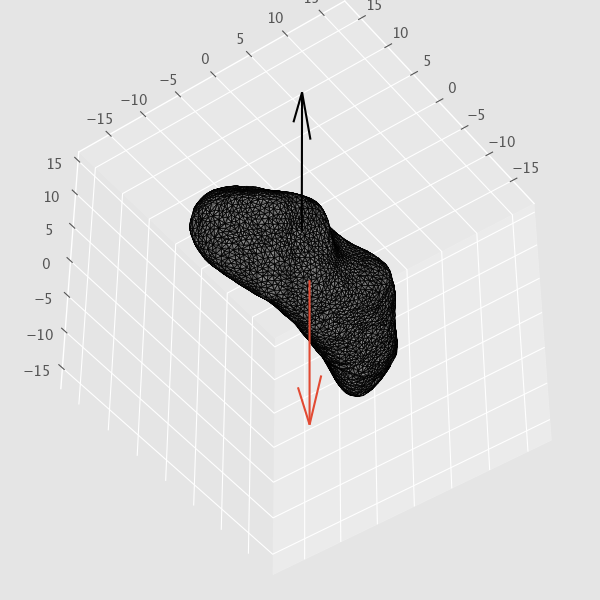

In [8]:
def draw_mesh(mesh):
    fig = plt.figure(figsize=(6, 6),frameon=False)
    ax = mplot3d.Axes3D(fig)

    # Collect face data as vectors for plotting
    F = mesh.elements

    facevectors = np.zeros((F.shape[0],3,3))
    for i, face in enumerate(F):
        for j in range(3):
            facevectors[i][j] = mesh.vertices[face[j],:]
    ax.add_collection3d(mplot3d.art3d.Poly3DCollection(facevectors, facecolor=[0.5,0.5,0.5], lw=0.5,edgecolor=[0,0,0], alpha=0.66))
    
    scale = mesh.vertices.flatten()
    
    I = trimesh.Trimesh(vertices=P,
                       faces=T,
                       process=False).moment_inertia
    Ip, Q = trimesh.inertia.principal_axis(I)
    ax.quiver(0,0,0,Q[2,0],Q[2,1],Q[2,2],length=20,normalize=False)
    ax.quiver(15,10,-10,0,0,20,length=1,normalize=False,color='k')
    ax.auto_scale_xyz(scale, scale, scale)

    plt.show()
    return fig

mesh = pymesh.form_mesh(P,T)
fig = draw_mesh(mesh)

In [39]:
# Calculations are done as follows: Probe the angles determining the direction of the 
# body axis (in red). Latitude β measured as the angle between body axis and 
# illumination (in black), given by positive rotation of β in (0,π) about the x-axis. 
# Angle λ in (0,2π) corresponds to rotation about the y-axis. All in all we
# use the YX'Z''- intrinsic rotation notation, where initially rotate λ about z-axis,
# then β about the new x-axis and finally rotate the body about the final z-axis

#λ = np.array([0.])
#β = np.array([π/3])
λ = np.linspace(0, π, 30)
β = np.linspace(0, 2*π, 31)
φ = np.linspace(0, 2*π, 31)

In [40]:
import time, datetime
Γ = np.zeros([φ.size, β.size, λ.size, 3])

start = time.time()
for i, fi in enumerate(φ):
    if np.mod(i,10)==0: print((i+1),'/',φ.size)
    for j, bj in enumerate(β):
        #print(' ',(j+1),'/',β.size)
        for k, lk in enumerate(λ):
            Γ[i,j,k:] = Γ_LS(P, T, C, N, φ = fi, β = bj, λ = lk, convex = True)
            #print('  ',(k+1),'/',λ.size)
end = time.time()
print('Done in', str(datetime.timedelta(seconds=np.round(end-start,0))))

1 / 31
11 / 31
21 / 31
31 / 31
Done in 0:07:48


<IPython.core.display.Javascript object>


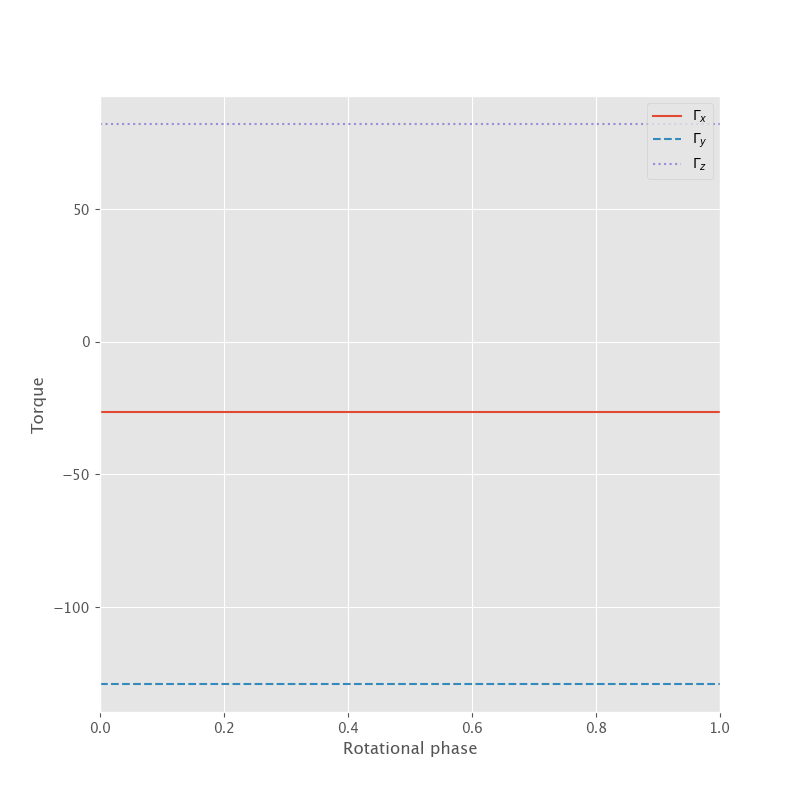

In [41]:
data = Γ.flatten()
np.savetxt('data.dat', data)
#data2 = np.loadtxt('data.dat')
#Γ = data2.reshape([φ.size, β.size, λ.size, 3])

fig = plt.figure(figsize=(8,8))
plt.plot(φ/(2*π),Γ[:,0,0,0],label=r'$Γ_x$')
plt.plot(φ/(2*π),Γ[:,0,0,1],'--',label=r'$Γ_y$')
plt.plot(φ/(2*π),Γ[:,0,0,2],':',label=r'$Γ_z$')
plt.xlabel('Rotational phase')
plt.ylabel('Torque')
plt.legend()
plt.xlim([0,1])
plt.show()

<IPython.core.display.Javascript object>


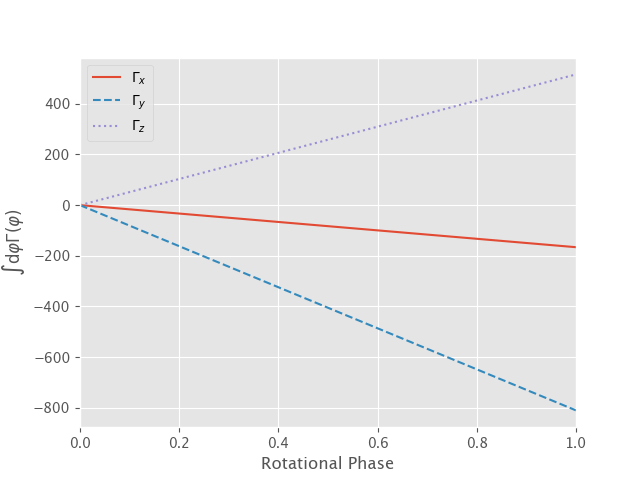

In [7]:
from scipy import integrate

fig = plt.figure()

Γx_int = integrate.cumtrapz(Γ[:,0,0,0], φ, initial=0)
Γy_int = integrate.cumtrapz(Γ[:,0,0,1], φ, initial=0)
Γz_int = integrate.cumtrapz(Γ[:,0,0,2], φ, initial=0)
plt.plot(φ/(2*π), Γx_int, '-',label=r'$Γ_x$')
plt.plot(φ/(2*π), Γy_int, '--',label=r'$Γ_y$')
plt.plot(φ/(2*π), Γz_int, ':',label=r'$Γ_z$')
plt.legend()
plt.xlim([0,1])
plt.xlabel('Rotational Phase')
plt.ylabel(r'$\int\mathrm{d}φ \Gamma(φ)$')

plt.show()

In [12]:
from IPython.display import clear_output

data = np.loadtxt('data.dat')
Γ = data.reshape([φ.size, β.size, λ.size, 3])

Γ2 = Γ
jjj = 0
for kkk in range(λ.size):
    for iii in range(β.size):
        βi = β[iii]
        λi = λ[kkk]
        R = Rot.from_euler('ZXY', [0, -βi, λi]).as_matrix()
        fig = plt.figure(figsize=plt.figaspect(0.5))
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')

        F = mesh.elements

        I = trimesh.Trimesh(vertices=P,
                           faces=T,
                           process=False).moment_inertia
        Ip, Q = trimesh.inertia.principal_axis(I)

        P2 = matmul(mesh.vertices,R)
        Q = matmul(R, Q)
        facevectors = np.zeros((F.shape[0],3,3))
        for i, face in enumerate(F):
            for j in range(3):
                facevectors[i][j] = P2[face[j],:]

        ax1.add_collection3d(mplot3d.art3d.Poly3DCollection(facevectors, facecolor=[0.5,0.5,0.5], lw=0.5,edgecolor=[0,0,0], alpha=0.66))
        ax1.quiver(0,0,0,Q[2,0],Q[2,1],Q[2,2],length=20,normalize=False,label="body axis")
        ax1.quiver(15,10,-10,0,0,20,length=1,normalize=False,color='k', label="illumination")

        scale = mesh.vertices.flatten()
        ax1.auto_scale_xyz(scale, scale, scale)
        ax1._axis3don = False
        ax1.legend()

        ax2 = fig.add_subplot(1, 2, 2)

        ax2.plot(φ/(2*π),Γ2[:,iii,kkk,0],label=r'$Γ_x$')
        ax2.plot(φ/(2*π),Γ2[:,iii,kkk,1],'--',label=r'$Γ_y$')
        ax2.plot(φ/(2*π),Γ2[:,iii,kkk,2],':',label=r'$Γ_z$')
        ax2.set_xlabel('Rotational phase')
        #ax2.set_ylabel('Torque')
        ax2.legend()
        ax2.set_xlim([0,1])
        #ax2.set_ylim([-3,3])
        plt.suptitle('Torque over rotation about the body axis for different body axis orientations')
        plt.savefig(str(jjj+1)+'.png')
        jjj += 1

    for iii in range(β.size-1):
        βi = β[-1 - iii]
        λi = λ[kkk]
        R = Rot.from_euler('ZXY', [0, -βi, λi]).as_matrix()
        fig = plt.figure(figsize=plt.figaspect(0.5))
        ax1 = fig.add_subplot(1, 2, 1, projection='3d')

        F = mesh.elements

        I = trimesh.Trimesh(vertices=P,
                           faces=T,
                           process=False).moment_inertia
        Ip, Q = trimesh.inertia.principal_axis(I)

        P2 = matmul(mesh.vertices,R)
        Q = matmul(R, Q)
        facevectors = np.zeros((F.shape[0],3,3))
        for i, face in enumerate(F):
            for j in range(3):
                facevectors[i][j] = P2[face[j],:]

        ax1.add_collection3d(mplot3d.art3d.Poly3DCollection(facevectors, facecolor=[0.5,0.5,0.5], lw=0.5,edgecolor=[0,0,0], alpha=0.66))
        ax1.quiver(0,0,0,Q[2,0],Q[2,1],Q[2,2],length=20,normalize=False,label="body axis")
        ax1.quiver(15,10,-10,0,0,20,length=1,normalize=False,color='k', label="illumination")

        scale = mesh.vertices.flatten()
        ax1.auto_scale_xyz(scale, scale, scale)
        ax1._axis3don = False
        ax1.legend()

        ax2 = fig.add_subplot(1, 2, 2)

        ax2.plot(φ/(2*π),Γ2[:,-1 - iii,kkk,0],label=r'$Γ_x$')
        ax2.plot(φ/(2*π),Γ2[:,-1 - iii,kkk,1],'--',label=r'$Γ_y$')
        ax2.plot(φ/(2*π),Γ2[:,-1 - iii,kkk,2],':',label=r'$Γ_z$')
        ax2.set_xlabel('Rotational phase')
        #ax2.set_ylabel('Torque')
        ax2.legend()
        ax2.set_xlim([0,1])
        #ax2.set_ylim([-3,3])
        plt.suptitle('Torque over rotation about the body axis for different body axis orientations')
        plt.savefig(str(jjj+1)+'.png')
        jjj += 1
        clear_output(wait=True)

3982
3983
3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181


8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703
8704
8705
8706
8707
8708
8709
8710
8711
8712
8713
8714
8715
8716
8717
8718
8719
8720
8721
8722
8723
8724
8725
8726
8727
8728
8729
8730
8731
8732
8733
8734
8735
8736
8737
8738
8739
8740
8741
8742
8743
8744
8745
8746
8747
8748
8749
8750
8751
8752
8753
8754
8755


<IPython.core.display.Javascript object>


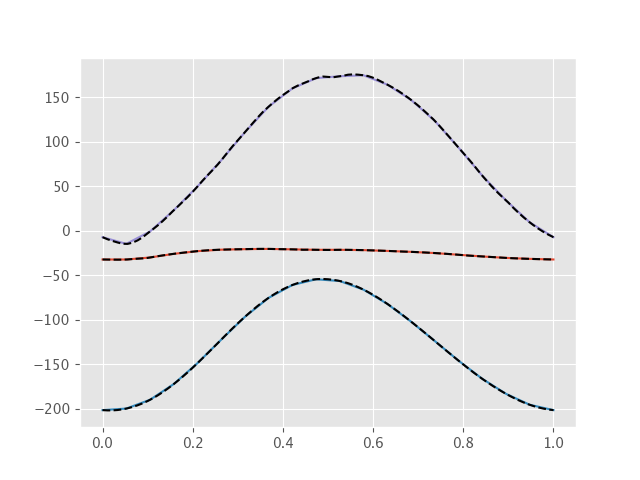

In [37]:
from scipy.interpolate import interpn
data = np.loadtxt('data.dat')
Γ = data.reshape([φ.size, β.size, λ.size, 3])
gx, gy, gz = np.meshgrid(φ,β,λ)
φn = np.linspace(0, 2*π, 20)
βn = β[0]
λn = λ[1]
gxn, gyn, gzn = np.meshgrid(φn,βn,λn)

xi = np.vstack(([[gxn.flatten()],[gyn.flatten()],[gzn.flatten()]])).T

values = interpn([φ,β,λ], Γ[:,:,:,:], xi)
#values = values.reshape(gxn.shape)
#print(values)
#fig = plt.matshow(Γ[:,:,0,0])
#plt.show()
fig = plt.figure()
plt.plot(φn/(2*π),values)
plt.plot(φ/(2*π), Γ[:,0,1,0],linestyle='--',c='k')
plt.plot(φ/(2*π), Γ[:,0,1,1],linestyle='--',c='k')
plt.plot(φ/(2*π), Γ[:,0,1,2],linestyle='--',c='k')
plt.show()

In [ ]:
# Alignment coordinates
ξ = np.linspace(0, π, 50)
φ = np.linspace(0, 2*π, 50)
ψ = 0

import time, datetime
Γ = np.zeros([ξ.size, 3])

start = time.time()
for i, xi in enumerate(ξ):
    if np.mod(i,1)==0: print((i+1),'/',ξ.size)
    for j, fj in enumerate(φ):
        #print(' ',(j+1),'/',β.size)
        Γ[i] += Γ_LS(P, T, C, N, φ = 0, β = xi, λ = fj)
            #print('  ',(k+1),'/',λ.size)
Γ = Γ/φ.size
end = time.time()
print('Done in', str(datetime.timedelta(seconds=np.round(end-start,0))))

In [ ]:
fig = plt.figure()
plt.plot(ξ,Γ[:,0],label=)
plt.show()